<h4>Домашнее задание</h4>

1. Сформировать с помощью sklearn.make_classification датасет из 100 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote).
2. Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.

3. *Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.

4. *(На повторение) Переписать функцию gini из урока про решающие деревья так, чтобы в качестве критерия использовалась энтропия Шэннона. Переименовать функцию в entropy.

1. Сформировать с помощью sklearn.make_classification датасет из 100 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote).

In [1]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification

import numpy as np

In [2]:
classification_data, classification_labels = make_classification(n_samples=100,
                                                                 n_features=2, n_informative=2, 
                                                                 n_classes=2, n_redundant=0, 
                                                                 n_clusters_per_class=1, random_state=23)

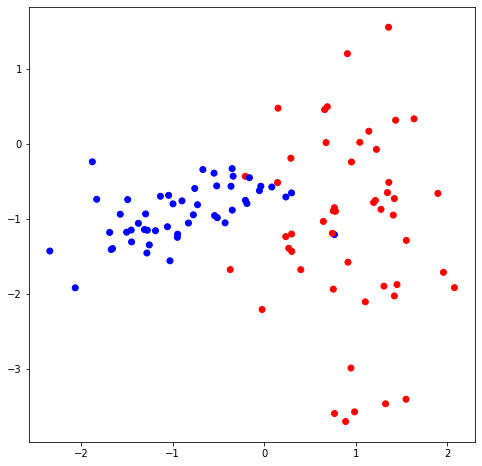

In [3]:
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(classification_data[:, 0], classification_data[:, 1], 
              c=classification_labels, cmap=colors);

In [4]:
#Создадим бустрапированные подвыборки
np.random.seed(42)

def get_bootstrap(data,labels,N):
    n_samples=data.shape[0]
    bootstrap=[]
    
    for i in range(N):
        sample_index=np.random.randint(0,n_samples,n_samples)
        b_data=data[sample_index]
        b_labels=labels[sample_index]
        
        bootstrap.append((b_data,b_labels))
    
    return bootstrap

In [5]:
#Сохраняем индексы признаков
def get_subsamples(len_samples):
    sample_indexes=list(range(len_samples))
    len_subsample=int(np.sqrt(len_samples))
    subsample=np.random.choice(sample_indexes,len_subsample,replace=False)
    return subsample

In [6]:
#Реализуем класс - узел
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [7]:
#Реализуем класс - лист
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
            
        # найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction     

In [8]:
# Расчет критерия Джини

# def gini(labels):
#     #  подсчет количества объектов разных классов
#     classes = {}
#     for label in labels:
#         if label not in classes:
#             classes[label] = 0
#         classes[label] += 1
    
#     #  расчет критерия
#     impurity = 1
#     for label in classes:
#         p = classes[label] / len(labels)
#         impurity -= p ** 2
        
#     return impurity

In [9]:
# Расчет прироста Джинни

# def gain(left_labels, right_labels, root_gini):

#     # доля выборки, ушедшая в левое поддерево
#     p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
#     return root_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [10]:
# Расчет энтропии

def entropy(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
        
    #  расчет критерия
    p_f = min(classes.values())/len(labels)
    p_s = max(classes.values())/len(labels)
    entropy =-(p_f*np.log2(p_f)+p_s*np.log2(p_s))
    
    return entropy

In [11]:
# Расчет прироста с применением энтропии
def gain_entropy(left_labels, right_labels, root_entropy):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return root_entropy - p * entropy(left_labels) - (1 - p) * entropy(right_labels)

In [12]:
# Разбиение датасета в узле

def split(data, labels, column_index, t):
    
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)
        
    true_data = data[left]
    false_data = data[right]
    
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [13]:
#Найдем лучшее разбиение:

def find_best_split(data,labels):
    
    min_leaf_samples=5
    
    #Разбиение с помощью Джинни
    #root_gini=gini(labels)
    #Разбиение с помощью Энтропии
    root_entropy=entropy(labels)
    
    best_gain=0
    best_t=None
    best_index=None
    
    n_features=data.shape[1]
    feature_subsample_indicies=get_subsamples(n_features)
    
    for index in feature_subsample_indicies:
        t_values=np.unique(data[:,index])
        
        for t in t_values:
            true_data,false_data,true_labels,false_labels=split(data,labels,index,t)
            
            if len(true_data)<min_leaf_samples or len(false_data)<min_leaf_samples:
                continue
            
            #Джинни
            #current_gain=gain(true_labels,false_labels,root_gini)
            
            #Энтропия
            current_gain=gain_entropy(true_labels,false_labels,root_entropy)
            
            if current_gain>best_gain:
                best_gain,best_t,best_index=current_gain,t,index
                
                
    return best_gain,best_t,best_index

In [14]:
#Построение дерева
def build_tree(data,labels):
    
    gain,t,index=find_best_split(data,labels)
    
    if gain==0:
        return Leaf(data,labels)
    
    true_data,false_data,true_labels,false_labels=split(data,labels,index,t)
    
    true_branch=build_tree(true_data,true_labels)
    false_branch=build_tree(false_data,false_labels)
    
    return Node(index,t,true_branch,false_branch)

In [15]:
#Построение леса
def random_forest(data,labels,n_trees):
    forest=[]
    bootstrap=get_bootstrap(data,labels,n_trees)
    
    for b_data,b_labels in bootstrap:
        forest.append(build_tree(b_data,b_labels))
        
    return forest

In [16]:
#Функция классификации отдельного объекта
def classify_object(obj,node):
    
    if isinstance(node,Leaf):
        answer=node.prediction
        return answer
    
    if obj[node.index]<=node.t:
        return classify_object(obj,node.true_branch)
    else:
        return classify_object(obj,node.false_branch)

In [17]:
#Функция формирования предсказания по выборке на одном дереве
def predict(data,tree):
    classes=[]
    for obj in data:
        prediction=classify_object(obj,tree)
        classes.append(prediction)
    return classes

In [18]:
#Предсказание голосование деревьев
def tree_vote(forest,data):
    predictions=[]
    
    for tree in forest:
        predictions.append(predict(data,tree))
        
    predictions_per_object=list(zip(*predictions))
    
    voted_predictions=[]
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj),key=obj.count))
        
    return voted_predictions

In [19]:
def accuracy_metric(actual,predicted):
    correct=0
    for i in range(len(actual)):
        if actual[i]==predicted[i]:
            correct+=1
    return correct/float(len(actual))*100.0

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
train_data,test_data,train_labels,test_labels=train_test_split(classification_data,
                                                              classification_labels,
                                                              test_size=0.3,
                                                              random_state=1)

<h5>Одно дерево в лесу</h5>

In [22]:
%%time
n_tree_1=1
my_forest_1=random_forest(train_data,train_labels,n_tree_1)

Wall time: 18 ms


In [23]:
train_answers_1=tree_vote(my_forest_1,train_data)

In [24]:
test_answers_1=tree_vote(my_forest_1,test_data)

In [25]:
#Точность на обучающей выборке
train_accuracy_1=accuracy_metric(train_labels,train_answers_1)

#Точность на тестовой выборке
test_accuracy_1=accuracy_metric(test_labels,test_answers_1)

print(f'Точность случайного лиса из {n_tree_1} деревьев: на тренировочной выборке: {np.round(train_accuracy_1,1)}, точность на тестовой выборке: {np.round(test_accuracy_1,1)}')

Точность случайного лиса из 1 деревьев: на тренировочной выборке: 88.6, точность на тестовой выборке: 73.3


<h5> Три дерева в лесу </h5>

In [26]:
%%time
n_tree_3=3
my_forest_3=random_forest(train_data,train_labels,n_tree_3)

Wall time: 58 ms


In [27]:
train_answers_3=tree_vote(my_forest_3,train_data)

In [28]:
test_answers_3=tree_vote(my_forest_3,test_data)

In [29]:
#Точность на обучающей выборке
train_accuracy_3=accuracy_metric(train_labels,train_answers_3)

#Точность на тестовой выборке
test_accuracy_3=accuracy_metric(test_labels,test_answers_3)

print(f'Точность случайного лиса из {n_tree_3} деревьев: на тренировочной выборке: {np.round(train_accuracy_3,1)}, точность на тестовой выборке: {np.round(test_accuracy_3,1)}')

Точность случайного лиса из 3 деревьев: на тренировочной выборке: 91.4, точность на тестовой выборке: 83.3


<h5>Десять деревьев в лесу</h5>

In [30]:
%%time
n_tree_10=10
my_forest_10=random_forest(train_data,train_labels,n_tree_10)

Wall time: 114 ms


In [31]:
train_answers_10=tree_vote(my_forest_10,train_data)

In [32]:
test_answers_10=tree_vote(my_forest_10,test_data)

In [33]:
#Точность на обучающей выборке
train_accuracy_10=accuracy_metric(train_labels,train_answers_10)

#Точность на тестовой выборке
test_accuracy_10=accuracy_metric(test_labels,test_answers_10)
print(f'Точность случайного лиса из {n_tree_10} деревьев: на тренировочной выборке: {np.round(train_accuracy_10,1)}, точность на тестовой выборке: {np.round(test_accuracy_10,1)}')

Точность случайного лиса из 10 деревьев: на тренировочной выборке: 95.7, точность на тестовой выборке: 90.0


<h5>Пятьдесят деревьев в лесу</h5>

In [34]:
%%time
n_tree_50=50
my_forest_50=random_forest(train_data,train_labels,n_tree_50)

Wall time: 699 ms


In [35]:
train_answers_50=tree_vote(my_forest_50,train_data)

In [36]:
test_answers_50=tree_vote(my_forest_50,test_data)

In [37]:
#Точность на обучающей выборке
train_accuracy_50=accuracy_metric(train_labels,train_answers_50)

#Точность на тестовой выборке
test_accuracy_50=accuracy_metric(test_labels,test_answers_50)
print(f'Точность случайного лиса из {n_tree_50} деревьев: на тренировочной выборке: {np.round(train_accuracy_50,1)}, точность на тестовой выборке: {np.round(test_accuracy_50,1)}')

Точность случайного лиса из 50 деревьев: на тренировочной выборке: 95.7, точность на тестовой выборке: 86.7


In [38]:
def get_mesh_grid(data,step=0.5,border=1.2):
    x_min,x_max=data[:,0].min()-border,data[:,0].max()+border
    y_min,y_max=data[:,1].min()-border,data[:,1].max()+border
    return np.meshgrid(np.arange(x_min,x_max,step),np.arange(y_min,y_max,step))

In [39]:
def create_voc(train_data,test_data):
    list_=[train_data,test_data]
    dict_={}
    i=1
    while i<5:
        dict_[i]=list_
        i+=1
    return dict_

In [40]:
def visualize(train_data,test_data):
    dict_data=create_voc(train_data,test_data)
    
    plt.figure(figsize = (16,28))

    # график обучающей выборки леса из одного дерева
    plt.subplot(4,2,1)
    xx, yy = get_mesh_grid(dict_data[1][0])
    mesh_predictions = np.array(tree_vote(my_forest_1,np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(dict_data[1][0][:, 0], dict_data[1][0][:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={train_accuracy_1:.2f}')

    # график тестовой выборки для леса из одного дерева
    plt.subplot(4,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(dict_data[1][1][:, 0], dict_data[1][1][:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={test_accuracy_1:.2f}')
    
    
    # график обучающей выборки для леса из трех деревьев
    plt.subplot(4,2,3)
    xx, yy = get_mesh_grid(dict_data[2][0])
    mesh_predictions = np.array(tree_vote(my_forest_3,np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(dict_data[2][0][:,0], dict_data[2][0][:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={train_accuracy_3:.2f}')

    # график тестовой выборки для леса из трех деревьев
    plt.subplot(4,2,4)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(dict_data[2][1][:,0], dict_data[2][1][:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={test_accuracy_3:.2f}')
    
    
    # график обучающей выборки для леса из десяти деревьев
    plt.subplot(4,2,5)
    xx, yy = get_mesh_grid(dict_data[3][0])
    mesh_predictions = np.array(tree_vote(my_forest_10,np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(dict_data[3][0][:,0], dict_data[3][0][:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={train_accuracy_10:.2f}')

    # график тестовой выборки для леса из десяти деревьев
    plt.subplot(4,2,6)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(dict_data[3][1][:,0], dict_data[3][1][:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={test_accuracy_10:.2f}')
    
    
    # график обучающей выборки для леса из пятидесяти деревьев
    plt.subplot(4,2,7)
    xx, yy = get_mesh_grid(dict_data[4][0])
    mesh_predictions = np.array(tree_vote(my_forest_50,np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(dict_data[4][0][:,0], dict_data[4][0][:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={train_accuracy_50:.2f}')

    # график тестовой выборки для леса из пятидесяти деревьев
    plt.subplot(4,2,8)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(dict_data[4][1][:,0], dict_data[4][1][:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={test_accuracy_50:.2f}')

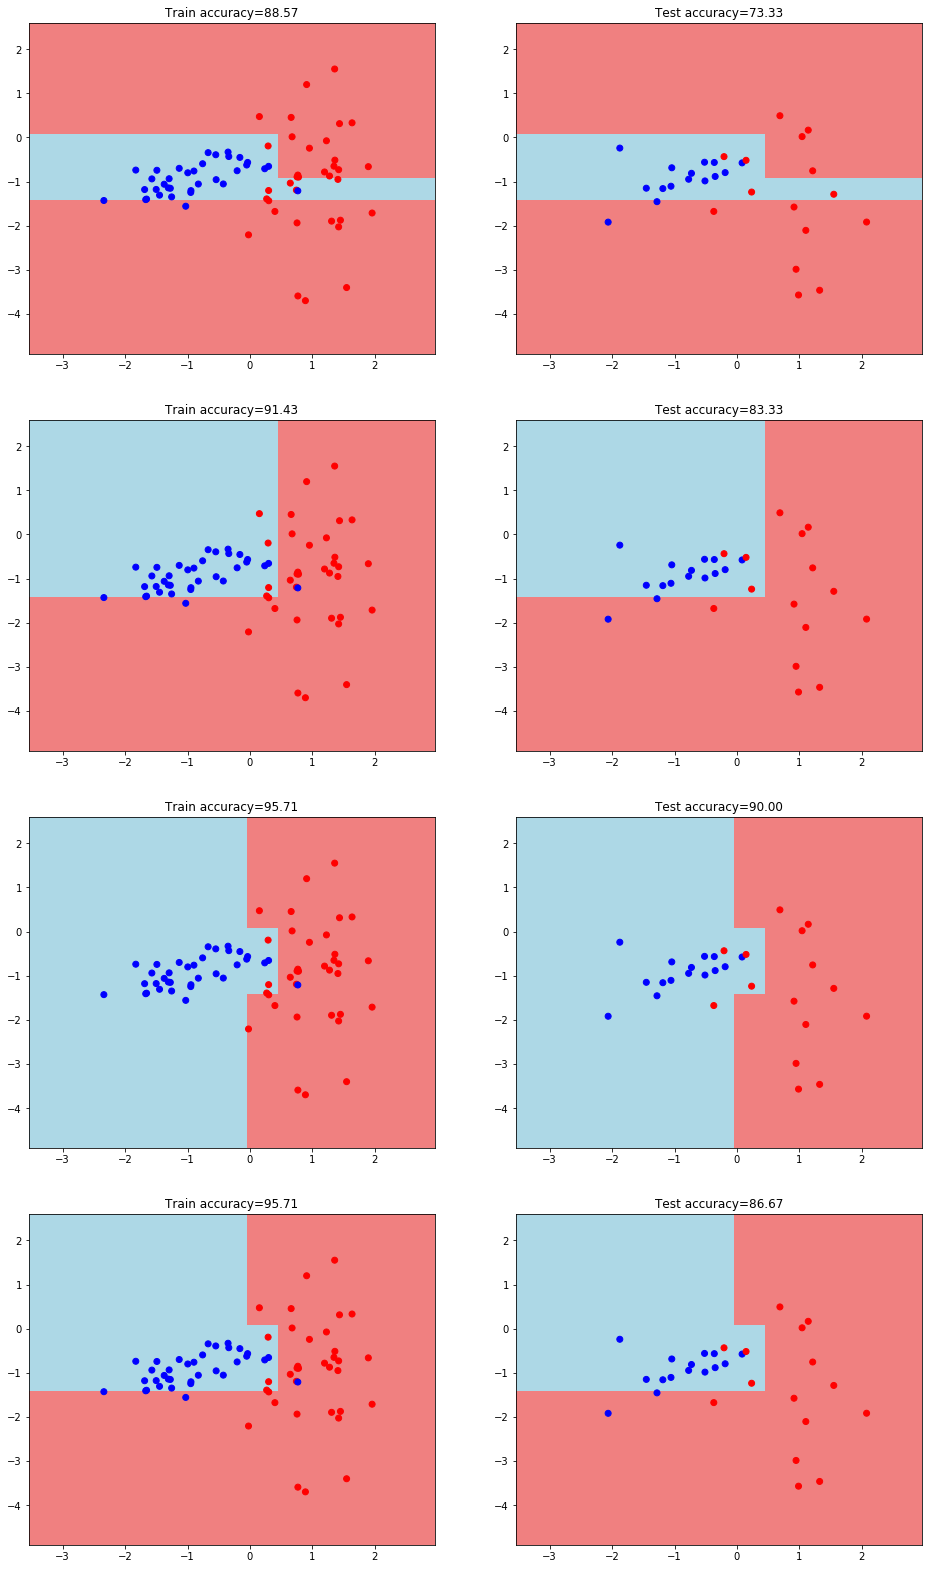

In [41]:
visualize(train_data,test_data)

2. Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.

Мы видим, что гиперплоскость становится сложнее при росте количества деревьев в лесу, при этом все более точно определяется ответ на тренировочной и тестовой выборке на 1, 3, 10  деревьях, однако, на 50 деревьях сложность гиперплоскости уже не обеспечивает точчный результат на тестовых данных, происходит переобучение. До 10 деревьев в лесу включительно происходит рост точности алгоритма на обучающей и на тестовой выборке, однако, на 50 деревьях мы видим уже слабое переобучение: алгоритм сохраняет точность на обучающей выборке при падении точности на тестовой.
Если посмотреть на график заивисимости точности на тренировочных данных и тестовых данных от количества деревьев в лесу (см. ниже), мы явно видим растущий тренд точности на тренировочных и тестовых данных (см. предложение 1), а далее выход на пилообразное плато - колебвания возле одних и тех же значений.

In [20]:
def train_test_accuracy(train_data,test_data,train_labels,test_labels):
    train_data_accuracy=[]
    test_data_accuracy=[]
    iterations_list=[]
    i=1
    while i<=50:
        n_tree=i
        my_forest=random_forest(train_data,train_labels,n_tree)
        train_answers=tree_vote(my_forest,train_data)
        test_answers=tree_vote(my_forest,test_data)
        train_accuracy=accuracy_metric(train_labels,train_answers)
        test_accuracy=accuracy_metric(test_labels,test_answers)
        train_data_accuracy.append(train_accuracy)
        test_data_accuracy.append(test_accuracy)
        iterations_list.append(i)
        i+=1
        
    
    return iterations_list,train_data_accuracy,test_data_accuracy

In [21]:
def draw_dynamics(train_data,test_data,train_labels,test_labels):
    plt.figure(figsize=(10,10))
    iterations_list,train_data_accuracy,test_data_accuracy=train_test_accuracy(train_data,test_data,train_labels,test_labels)
    plt.plot(iterations_list,train_data_accuracy,color='b')
    plt.plot(iterations_list,test_data_accuracy,color='r')
    plt.show()
    
    

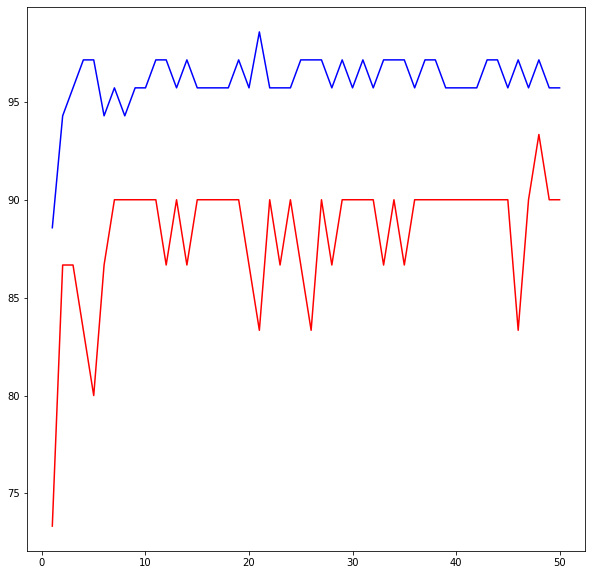

In [22]:
draw_dynamics(train_data,test_data,train_labels,test_labels)

4. *(На повторение) Переписать функцию gini из урока про решающие деревья так, чтобы в качестве критерия использовалась энтропия Шэннона. Переименовать функцию в entropy.

In [ ]:
#См. решение в задаче 1, функции: def entropy, def gain_entropy -  после def gini